### Example 4 - Unpublished Data: Build a Trade Heuristic

In this example, we'll create a heuristic for estimating trade activity in a day of the market.  Some trades
we can infer from changes in the order book between snapshots.  However, this usually doesn't reveal all trades as there is
ambiguity in whether an order was removed because it was canceled, or because it was completely filled \(and hence, a trade\).  In these cases, we'll attempt to estimate which orders were removed because they were completely filled.

Before we can estimate trade activity, we need to deal with data quality issues in order book data.  Such issues are not uncommon in the real world of data science.  In the case of order book data, we'll show that some orders occasionally disappear from snapshots only to later appear in the data.  We can fix most of these problems although we don't have enough information to claim we've fixed all such gaps.  Once we've applied our fix to the data, we continue with our analysis on trade estimation.

This example dives more deeply into analysis than previous examples.  We'll find that trades that we can unambiguously infer from the data only make up a fraction of the total trades in a day.  Furthermore, the "obvious" choice for inferring the remainder of the trades overshoots signficantly.  We'll formulate a hypothesis for inferring which remaining trades to include \(as opposed to considering such trades as cancels\), and we'll finish with an example of back testing our hypothesis.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# We'll use a day of Tritanium trading in The Forge to develop our heuristic.
# This cell loads various static information about Tritanium and The Forge.
#
sde_client = Client.SDE.get()
type_query = "{values: ['Tritanium']}"
region_query = "{values: ['The Forge']}"
type_id = sde_client.Inventory.getTypes(typeName=type_query).result()[0][0]['typeID']
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
compute_date = convert_raw_time(1483228800000) # 2017-01-01 12:00 AM UTC
print("Using type_id=%d, region_id=%d at %s" % (type_id, region_id, str(compute_date)))

Using type_id=34, region_id=10000002 at 2017-01-01 00:00:00


In [3]:
# We'll use book data we downloaded for a previous example and import the data as a Pandas DataFrame.
# If you don't have this data, you can create it by following the instructions towards the end of
# the Jupyter notebook for Example 2.
#
from evekit.marketdata import OrderBook

order_book = OrderBook.get_data_frame(dates=[compute_date], types=[type_id], regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2017-01-01 00:00:00...done


Before we start analyzing trade data, there's one important problem we have to fix first.  As mentioned in the text, there are sometimes gaps in the data provided by CCP.  These gaps cause orders to occasionaly disappear from order book snapshots, only to re-appear again in a later snapshot.  This can confuse our trade heuristic which attempts to infer trades by looking at differences between subsequent snapshots.

In [4]:
# To see an example of this problem, we can look for orders which should be in the first snapshot
# but which are missing.  These will be orders with an issue date before our sample date.  Here's
# how we can find them:
#
# Filter for orders which existed on the book before our sample date
#
existing_orders = order_book[order_book.issued < compute_date]
existing_groups = list(existing_orders.groupby(existing_orders.index))
#
# Iterate through snapshots looking for existing orders which appear in a later snapshot, but
# are missing from the first snapshot.  We know these orders should appear in the first snapshot
# since they existed before our sample date.  We'll stop on the first missing orders we find.
#
for i in range(1, len(existing_groups) + 1):
    # Compute orders ids missing from the first snapshot
    missing = set(existing_groups[i][1].order_id).difference(set(existing_groups[0][1].order_id))
    if len(missing) > 0:
        print("Found missing orders at snapshot " + str(i))
        print(str(missing))
        break

Found missing orders at snapshot 2
{4720076544, 4712425570, 4721400485, 4719199240, 4696653833, 4718157929, 4730912813, 4715405454, 4727375151, 4716764432, 4731198801, 4716741874, 4716037105, 4722607129, 4697570970, 4722031931, 4724847836, 4722004445, 4726628766}


In [5]:
# Let's look at the first missing order.  We can verify it should appear in the first snapshot by checking the issue date:
#
order_book[order_book.order_id == 4720076544].ix[0]

buy                             False
date              2017-01-01 00:10:00
duration                           90
issued            2016-12-19 21:50:38
location_id                  60003760
min_volume                          1
order_id                   4720076544
order_range                    region
price                             5.8
region_id                    10000002
type_id                            34
volume                       49446738
volume_entered               49446738
Name: 2017-01-01 00:10:00, dtype: object

(736330.0, 736330.9965277778)

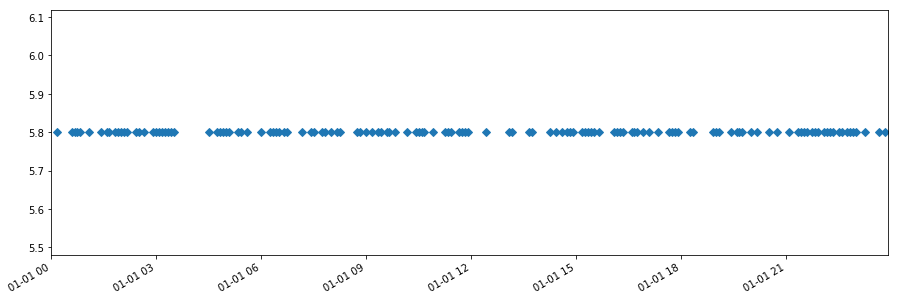

In [6]:
# The issue date is clearly before our target date so this order should definitely be in the first snapshot.
# In fact, this order is missing from many snapshots.  A graph of all appearances of this order shows the gaps:
#
ax = order_book[order_book.order_id == 4720076544].price.plot(figsize=[15,5], style='D')
ax.set_xlim(datetime.datetime(2017,1,1,0,0,0), datetime.datetime(2017,1,1,23,55,0))

In [7]:
# Because this is a common problem, we'ved added a "fill_gaps" option to the order book loader which will
# backfill gaps when it's clear an order is missing.  When the order loader detects a gap, it works 
# backwards from the snapshot where the gap was detected, inserting the order into any missing snapshot
# until it finds a snapshot with a timestamp before the issue date of the order, or it finds a snapshot
# where the order already exists.
#
# Let's re-load the order book to see how this fixes our problem.  Note the "fill_gaps" option we've included
# in the configuration dictionary:
#
order_book = OrderBook.get_data_frame(dates=[compute_date], types=[type_id], regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, fill_gaps=True, verbose=True))

Retrieving 2017-01-01 00:00:00...done


(24720480, 24721915)

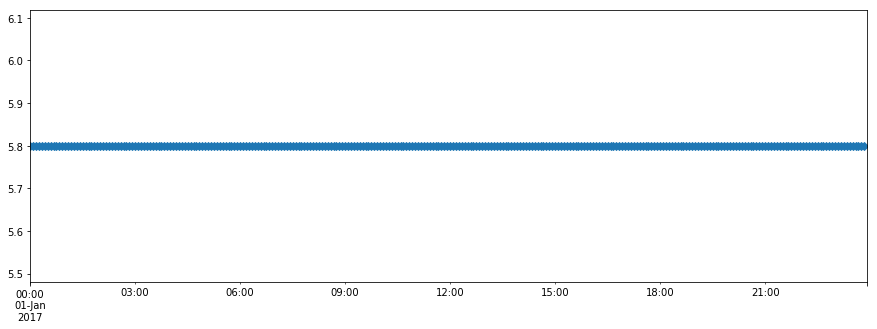

In [8]:
# The plot of this order shows that all gaps have been filled:
#
ax = order_book[order_book.order_id == 4720076544].price.plot(figsize=[15,5], style='D')
ax.set_xlim(datetime.datetime(2017,1,1,0,0,0), datetime.datetime(2017,1,1,23,55,0))

Henceforth, we'll use the "fill_gaps" feature any time having gap free data is important.  Let's move now to inferring trades from the order book.

A quick review of EVE market mechanics tells us that once an order is placed, it can only be changed in the following ways:

* The price can be changed.  Changing price also resets the issue date of the order.
* The order can be canceled.  This removes the order from the order book.
* The order can be partially filled.  This reduces volume for the order, but otherwise the order remains in the order book.
* The order can be completely filled.  This removes the order from the order book.

Since a partially filled order is the only unambiguous indication of a trade, let's start by building our heuristic to catch those events.

In [9]:
# The following function will be our trade inferrer.  It will operate on the order book we loaded into a DataFrame above.
# Note that it is more correct to also include the last snapshot of the previous day into our order book in order to
# detect trades which occur in the first snapshot of the day.  We're ignoring this detail for this example.
#
# The result of this function is a DataFrame containing inferred trades.
#
def infer_trades(order_book):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        # We're interested in the set of orders which are present in both snapshots and for which
        # volume changed.
        current_snap = current[1]
        next_snap = next[1]
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        # If we've found any changed orders, then these are trades
        for next_change in changed_orders.index:
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

In [10]:
# Let's test our trade inferrer on the sample book:
trades = infer_trades(order_book)
trades

,buy,location,order_id,price,timestamp,volume
2017-01-01 00:10:00,True,None,4733760768,4.66,2017-01-01 00:10:00,79878800
2017-01-01 00:10:00,True,None,4726038430,4.63,2017-01-01 00:10:00,11351822
2017-01-01 00:10:00,False,60015027,4734004757,4.28,2017-01-01 00:10:00,21111
2017-01-01 00:15:00,True,None,4733760768,4.66,2017-01-01 00:15:00,7239766
2017-01-01 00:20:00,True,None,4733760768,4.66,2017-01-01 00:20:00,2973510
2017-01-01 00:20:00,False,60015027,4734004757,4.28,2017-01-01 00:20:00,1
2017-01-01 00:25:00,True,None,4733760768,4.66,2017-01-01 00:25:00,5063931
2017-01-01 00:25:00,False,60015027,4734004757,4.28,2017-01-01 00:25:00,6528
2017-01-01 00:30:00,True,None,4733760768,4.66,2017-01-01 00:30:00,926
2017-01-01 00:35:00,True,None,4733760768,4.66,2017-01-01 00:35:00,102800


In [11]:
# We know that we may be missing trades which completely fill market orders.
# We can get a sense as to how far off we are by comparing the the total volume of
# inferred trades versus the market history for the same day.
#
from evekit.marketdata import MarketHistory
market_history = MarketHistory.get_data_frame(dates=[compute_date], types=[type_id], regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2017-01-01 00:00:00...done


In [12]:
# Let's see how we did in terms of volume...
missing_volume = market_history.ix[compute_date].volume - trades.volume.sum()
"{:,d}".format(missing_volume)

'7,436,756,530'

In [13]:
# We're off quite a bit.  This is only one day of data, so we shouldn't draw too many conclusions,
# but let's take a look at the relative volumes.
#
"{:.2f}%".format(trades.volume.sum() / market_history.ix[compute_date].volume * 100)

'40.61%'

In [14]:
# So we can recover about 40% of the daily volume from partial fills for this day.  That leaves us
# to estimate complete fills, but it also tells us this is an important estimate as more than
# half of this day's trading volume came from complete fills.
#
# We'll start with a naive approach, where we assume every order present in one snapshot, but removed
# in the next is a complete fill.  We know this is wrong, but maybe the estimate is close enough
# that we can ignore including a few cancels in our estimate.  Since some trades will now be guesses
# (instead of provable partial fills), we'll add a new "actual" field to the results so we can 
# distinguish which trades we're estimating.
#
# Here's the new version of our heuristic:
#
def infer_trades_2(order_book):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # First, look for orders present in both snapshots but have their volume changed
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': True,
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
        # Second, look for orders which are removed between snapshots.  We'll treat these
        # as completely filled orders for now.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            location = next_line.location_id
            if next_line.buy and next_line.order_range != 'station':
                # See above
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': False,
                'buy': next_line.buy, 
                'order_id': order_id, 
                'price': next_line.price,
                'volume': next_line.volume, 
                'location': str(location)})                
    # Return result
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

In [15]:
# Let's see how are inferred volume compares now.
#
trades_2 = infer_trades_2(order_book)
missing_volume_2 = market_history.ix[compute_date].volume - trades_2.volume.sum()
print("total orders: %d  inferred orders: %d  missing volume: %d" % (len(trades_2), 
                                                                     len(trades_2[trades_2.actual == False]),
                                                                     missing_volume_2))

total orders: 923  inferred orders: 260  missing volume: -10314278939


In [16]:
# We've overshot a bit on volume.  Specifically:
#
"{:.2f}%".format(trades_2.volume.sum() / market_history.ix[compute_date].volume * 100)

'182.37%'

In [17]:
# However, we've only recovered a third of the trades for the day.
#
"{:.2f}%".format(len(trades_2) / market_history.ix[compute_date].order_count * 100)

'32.70%'

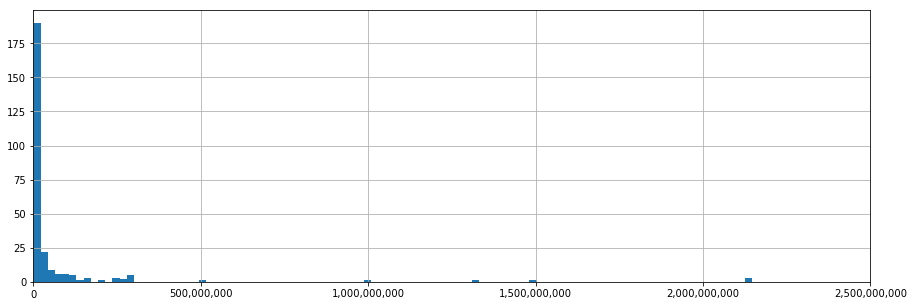

In [18]:
# At this point, we've recovered all the possible trades we can see in the data which 
# suggests a substantial number of trades are occurring between snapshots.  If these
# trades are partial fills, then we're already capturing the volume but have no mechanism
# to capture the individual trades.  It's also possible that limit orders are being 
# placed and filled between snapshots.  We have no way to capture these trades as they
# are not visible in the data.  Given the short duration between snapshots (5 minutes at
# time of writing), it seems unlikely we're missing very short lived limit orders.
#
# Since we can't match trade count, we'll instead focus on trying to more closely
# match volume for the day.  We know that some removed orders must be cancels and
# not complete fills.  Perhaps this is related to volume.  Let's take a look
# at a histogram of the volume of the data from inferred trades (i.e. trades which are
# either complete fills or cancels).
#
ax = trades_2[trades_2.actual == False].volume.hist(bins=100, figsize=[15,5])
ax.set_xlim([0, 2500000000])
ax.get_xaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))

In [19]:
# From inspection, there are very clear outliers.  In fact, it looks like trades
# with volume above 500M may actually be cancels instead of trades.  Why would
# we draw this conclusion?  Because trades this large would represent a substantial 
# portion of daily volume.  In particular:
#
big_trades = trades_2[trades_2.actual == False]
big_trade_amount = big_trades[big_trades.volume > 500000000].volume.sum()
order_fraction = big_trade_amount / market_history.ix[compute_date].volume * 100
#
print("Big trade ratio of daily volume: %s\n" % "{:,.2f}%".format(order_fraction))
#
less_big_orders = (trades_2.volume.sum() - big_trade_amount) / market_history.ix[compute_date].volume * 100
#
print("Trade volume ratio less large trades: %s\n" % "{:,.2f}%".format(less_big_orders))

Big trade ratio of daily volume: 81.85%

Trade volume ratio less large trades: 100.51%



In [20]:
# The sum of the "trades" above 500M represent more than 80% of daily volume.  Moreover,
# when we look at total volume after removing these trades, we can almost exactly match
# the known historical volume for the day.
#
# This analysis suggests a very simple strategy for distinguishing complete fills from cancels:
#
# if an inferred trade has volume less than some threshold, it's a complete fill.
# otherwise, the trade is actually a cancel.
#
# If this is our strategy, what should we use for a threshold?  We can't conclude that
# 500M will always be the appropriate threshold.  For one thing, each asset type
# will have a different threshold.  For another, as volume changes daily, it's likely
# the appropriate threshold will change daily as well.  A better choice might be
# to base our threshold on a percentage of daily volume.  That way, our threshold will 
# adjust as volume changes over time.
#
# Perhaps a reasonable place to start is to look at how the threshold for our sample day
# compares to historical volume:
#
500000000 / market_history.ix[compute_date].volume

0.039927860338333718

We don't have much data to suggest 4% of daily volume (approximately) is the right threshold.  But, for the sake of completing this example, let's assume this is the correct ratio.  We'll now turn to backtesting our new strategy.

In [21]:
# To test the validity of our strategy, we'll add code to decide complete fills versus cancels
# based on a volume threshold.
#
# Here's the final version of our trade inference algorithm:
#
def infer_trades_3(order_book, volume_threshold):
    inferred_trades = []
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # First, look for orders present in both snapshots but have their volume changed
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            # Create the trade object
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'actual': True,
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
        # Second, look for orders which are removed between snapshots.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            # If the volume of a removed order does not exceed the threshold, then keep it.
            if next_line.volume <= volume_threshold:
                location = next_line.location_id
                if next_line.buy and next_line.order_range != 'station':
                    # See above
                    location = None
                inferred_trades.append({
                    'timestamp': next[0],
                    'actual': False,
                    'buy': next_line.buy, 
                    'order_id': order_id, 
                    'price': next_line.price,
                    'volume': next_line.volume, 
                    'location': str(location)})                
    # Return result
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

We'll now move to backtesting our strategy.  Since we want to be able to infer trades on a day for which we don't yet have historic data \(e.g. the current day\), we'll set the volume threshold to be 4% of the five day moving average of daily volume.  We need historic book and market history for our backtest, with slightly more market history so that we can compute the moving average for the first day of our backtest.  We'll perform the back test over 30 days of historic data.

The next two cells \(after we set date ranges\) are for downloading market data if you don't already have it local.  We suggest you do this on a fast connection.  If, instead, you want to use live data, you can skip the next two cells and remove the `local_storage` option from the order book and market data loaders.

In [22]:
# Set dates for the back test.  The first date range is the range of the test.  The second date range is
# the range of historic data we need to compute volume thresholds.
#
date_range = pd.date_range(compute_date - datetime.timedelta(days=30), compute_date)
history_date_range = pd.date_range(compute_date - datetime.timedelta(days=35), compute_date)

In [23]:
#
# WARNING: this cell will take some time to evaluate if your connection is slow
#
# You can evaluate this cell to download a month of data from compute_date
#
from evekit.online.Download import download_order_book_range
download_order_book_range(date_range, ".", types=[type_id], regions=[region_id], config={'verbose': True, 'tree': True})

In [24]:
#
# WARNING: this cell will take some time to evaluate if your connection is slow
#
# We need historic market summaries as well, this cell will download those if you don't have them already.
# Note that we extend the range by five days so we can start the backtest on 2016-12-02.
#
from evekit.online.Download import download_market_history_range
download_market_history_range(history_date_range, ".", dict(skip_missing=True, tree=True, verbose=True))

In [25]:
# Reload market history to get the complete range.
#
market_history = MarketHistory.get_data_frame(dates=history_date_range, types=[type_id], regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-11-27 00:00:00...done
Retrieving 2016-11-28 00:00:00...done
Retrieving 2016-11-29 00:00:00...done
Retrieving 2016-11-30 00:00:00...done
Retrieving 2016-12-01 00:00:00...done
Retrieving 2016-12-02 00:00:00...done
Retrieving 2016-12-03 00:00:00...done
Retrieving 2016-12-04 00:00:00...done
Retrieving 2016-12-05 00:00:00...done
Retrieving 2016-12-06 00:00:00...done
Retrieving 2016-12-07 00:00:00...done
Retrieving 2016-12-08 00:00:00...done
Retrieving 2016-12-09 00:00:00...done
Retrieving 2016-12-10 00:00:00...done
Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2

In [26]:
# Now run the backtest, storing the results in a DataFrame for further analysis.
# Note the use of "fill_gaps" in the order book loader.
#
volume_thresh_series = market_history.volume.rolling(window=5, center=False).mean()
test_results = []
volume_multiplier = 0.04
for test_date in date_range:
    test_book = OrderBook.get_data_frame(dates=[test_date], types=[type_id], regions=[region_id], 
                                         config=dict(local_storage=".", tree=True, skip_missing=True, 
                                                     fill_gaps=True, verbose=True))
    test_trades = infer_trades_3(test_book, volume_thresh_series.ix[test_date] * volume_multiplier)
    test_results.append({
        'date': test_date,
        'trade_count': len(test_trades),
        'trade_volume': test_trades.volume.sum(),
        'historic_count': market_history.ix[test_date].order_count,
        'historic_volume': market_history.ix[test_date].volume
    })
test_results_df = DataFrame(test_results, index=[x['date'] for x in test_results])
test_results_df

Retrieving 2016-12-02 00:00:00...done
Retrieving 2016-12-03 00:00:00...done
Retrieving 2016-12-04 00:00:00...done
Retrieving 2016-12-05 00:00:00...done
Retrieving 2016-12-06 00:00:00...done
Retrieving 2016-12-07 00:00:00...done
Retrieving 2016-12-08 00:00:00...done
Retrieving 2016-12-09 00:00:00...done
Retrieving 2016-12-10 00:00:00...done
Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2016-12-23 00:00:00...done
Retrieving 2016-12-24 00:00:00...done
Retrieving 2016-12-25 00:00:00...done
Retrieving 2016-12-26 00:00:00...done
Retrieving 2016-12-27 00:00:00...done
Retrieving 2

,date,historic_count,historic_volume,trade_count,trade_volume
2016-12-02,2016-12-02,3631,18556468661,1199,18433392598
2016-12-03,2016-12-03,3987,23656393057,1254,18679178018
2016-12-04,2016-12-04,4405,23724867157,1267,22354956089
2016-12-05,2016-12-05,3534,19141332549,1064,20480693749
2016-12-06,2016-12-06,3677,15651461252,1193,16969774272
2016-12-07,2016-12-07,3417,12717852113,1149,15119217185
2016-12-08,2016-12-08,3425,20708633301,1069,21694935703
2016-12-09,2016-12-09,3456,12928838084,1210,14296703476
2016-12-10,2016-12-10,4072,26555598594,1191,18131858063
2016-12-11,2016-12-11,4197,14006696844,1187,12588367680


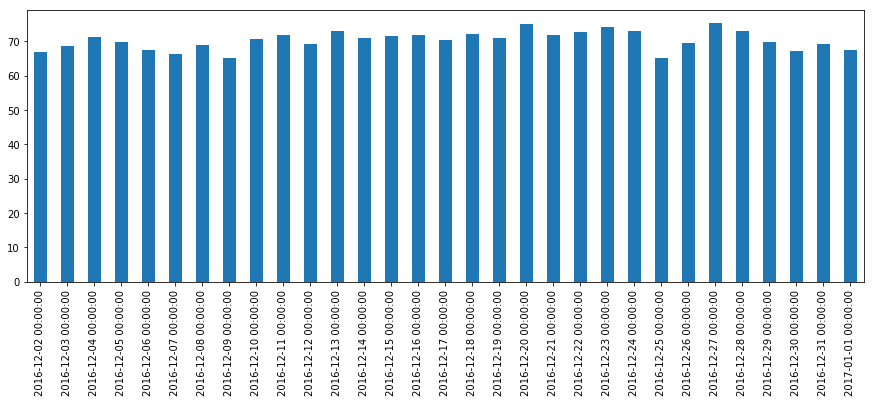

In [27]:
# We can graph the results in various ways to analyze performance.  We know that we are unlikely
# to capture trade count accurately, but here's a graph of the difference as a percent of the
# historic order count (closer to zero is better).
#
((test_results_df.historic_count - test_results_df.trade_count).abs()\
 /test_results_df.historic_count * 100).plot(kind='bar', figsize=[15,5])

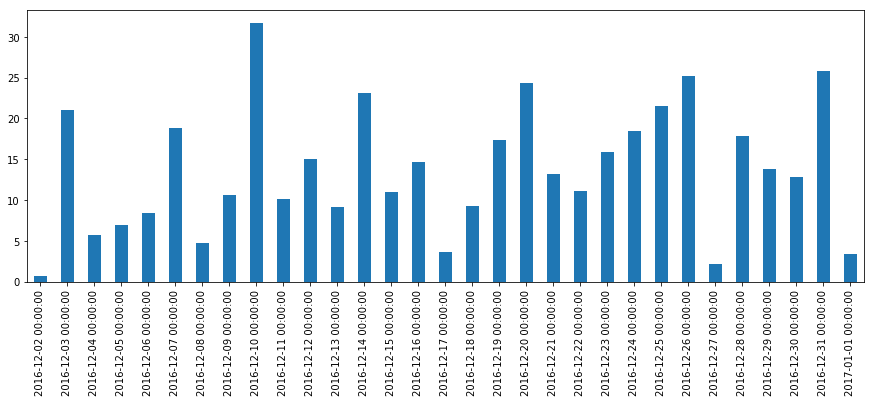

In [28]:
((test_results_df.historic_volume - test_results_df.trade_volume).abs()\
 / test_results_df.historic_volume * 100).plot(kind='bar',figsize=[15,5])

Again, some days are worse than others, but there are many days within 20% of actual which is likely good enough for our use.  We leave a more careful analysis as an exercise for the reader.

The EveKit libraries do not include any explcit support for trade analysis such as we described above.  The highly heuristic nature of this analsyis makes it difficult to provide a standard offering.  As we'll see in later chapters, the basic analysis above can be adapted to the specific needs of a particular trading strategy.